# Vehicle Detection and Tracking
## The goal of this project is to detect and track any vehicle which is in range of the vehicle. The pipeline to achieve this is as follows:
1. Train a classifier to distinguish car images from non car images.
2. Search in image using sliding window whether a car is detected.
3. Add heatmap to remove false positives.
4. Draw bounding box across detected cars.

In [1]:
import glob
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

%matplotlib inline

# Data Exploration
For vehicle classification, I used full dataset provided. Following are the stats of data:
Number of car Images:  8792
Number of not car Images :  8968
Image Shape :  (64, 64, 3)
Image Data type :  float32

In [2]:
# Read in cars and notcars
images = glob.glob('vehicles/*/*.png')
cars = []
notcars = []
for image in images:
        cars.append(image)
        
images = glob.glob('non-vehicles/*/*.png')
for image in images:
        notcars.append(image)        


Number of car Images:  8792
Number of not car Images :  8968
Image Shape :  (64, 64, 3)
Image Data type :  float32


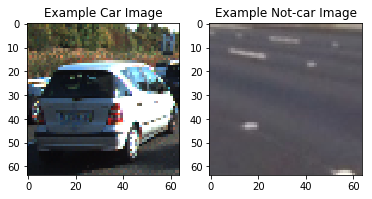

In [3]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print("Number of car Images: ", data_info["n_cars"])
print("Number of not car Images : ", data_info["n_notcars"])
print("Image Shape : ", data_info["image_shape"])
print("Image Data type : ", data_info["data_type"])




# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# Parameters Used after Tuning
I used spatial features,histogram features and hog features to classify car.I used pix_per_cell as 16 as conceptually more pixels in cell should result in faster processing. On Experimentation, YCrCb colorspace was giving better results.I used 'ALL' hog_channel to maximixe number of features. 

In [4]:

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


xy_window_size = (96, 96)
xy_overlap_size = (0.8, 0.8)



### These functions are  adapted from the lesson.py provided with lessons.

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,visualization=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        
        if visualization == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                            hog_feature, hog_image = get_hog_features(feature_image[:, :, channel],
                                                                  orient, pix_per_cell, cell_per_block,
                                                                  vis=True, feature_vec=True)
                            hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                               pix_per_cell, cell_per_block, vis=True, feature_vec=True)

                fig = plt.figure()
                plt.subplot(121)
                plt.imshow(image)
                plt.title('Car Image')
                plt.subplot(122)
                plt.imshow(hog_image)
                plt.title('Example HOG Visualization')               
        else:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                        hog_feature = get_hog_features(feature_image[:, :, channel],
                                                       orient, pix_per_cell, cell_per_block,
                                                       vis=False, feature_vec=True)
                        hog_features.append(hog_feature)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)  
            
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [6]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# HOG Visualization
Following is the HOG Visualization of a sample car image.

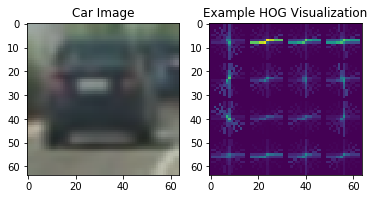

In [7]:
sample_car = [cars[0]]
sample_notcar = [notcars[0]]
# Plot HOG visualisation
features = extract_features(sample_car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,
                        visualization=True)

# Vehicle Classification

The vehicle is classified using Linear SVC classification algorithm. Firstly the histogram, spatial and Hog features of vehicle and non vehicle images are extracted, then the features are scaled so that no one feature dominate over others.

Then the image set is split between training and test data in ratio of 0.8:0.2. 

In [8]:

# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2148


In [9]:
import time
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

7.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9854


In [ ]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    """Returns heatmap with false positives removed."""
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image copy with boxes drawn
    return imcopy



    

In [12]:

def process_image(img):
    
    draw_image = np.copy(img)

    # Rescale data since training data extracted from 
    # .png images (scaled 0 to 1 by mpimg) and image we
    # are searching is .jpg (scaled 0 to 255)
    image = np.zeros((img.shape[0], img.shape[1]), np.float32)
    image = img.astype(np.float32)/255
    print(image.dtype)
    
    
    # Get list of windows to search at this stage.
    windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[350,700], 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size)

    # Return all the windows the classifier has predicted contain car(s) ('positive windows').
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # Draw bounding boxes around the windows that the classifier predicted has cars in them
    window_img = draw_boxes(draw_image, hot_windows)                    

    return (window_img)


# Detected Window Visualization

float32


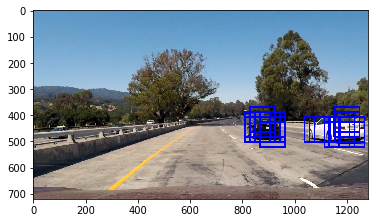

In [13]:


image = mpimg.imread('test_images/test1.jpg')
fin_img = process_image(image)
plt.imshow(fin_img)

float32


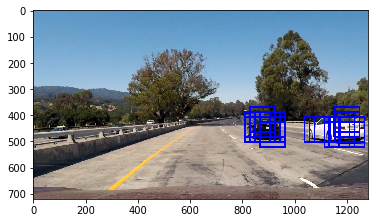

In [14]:
image1 = mpimg.imread('test_images/test2.jpg')
fin_img = process_image(image)
plt.imshow(fin_img)


float32


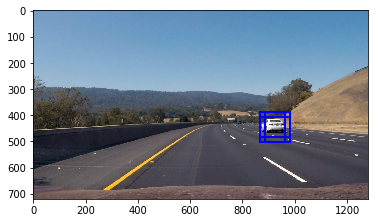

In [15]:
image = mpimg.imread('test_images/test3.jpg')
fin_img = process_image(image)
plt.imshow(fin_img)

float32


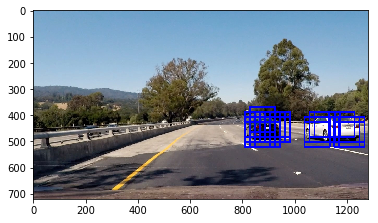

In [16]:
image = mpimg.imread('test_images/test4.jpg')
fin_img = process_image(image)
plt.imshow(fin_img)

float32


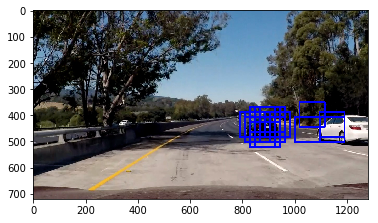

In [17]:
image = mpimg.imread('test_images/test5.jpg')
fin_img = process_image(image)
plt.imshow(fin_img)

In [18]:
from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, heatmap):
    # Generate the labels from the heat map.
    labels = label(heatmap)
    # Keep a list of bboxes for detected vehicles.
    bboxes = []
    # Iterate through all detected vehicles.
    for vehicle in range(1, labels[1]+1):
        # Find pixels with each vehicle label value.
        nonzero = (labels[0] == vehicle).nonzero()
        # Identify x and y values of those pixels.
        nonzerox = np.array(nonzero[0])
        nonzeroy = np.array(nonzero[1])
        # Define a bounding box based on the min/max x and y.
        bbox = ((np.min(nonzeroy), np.min(nonzerox)), (np.max(nonzeroy), np.max(nonzerox)))
        bboxes.append(bbox)
    # Draw the bounding boxes for the detected vehicles.
    img = draw_boxes(img, bboxes)
    # Return the annotated image.
    return img

In [19]:
def pipeline_image(img):
    
    draw_image = np.copy(img)

    # Rescale data since training data extracted from 
    # .png images (scaled 0 to 1 by mpimg) and image we
    # are searching is .jpg (scaled 0 to 255)
    image = np.zeros((img.shape[0], img.shape[1]), np.float32)
    image = img.astype(np.float32)/255
   
    
    
    # Get list of windows to search at this stage.
    windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[350,700], 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size)

    # Return all the windows the classifier has predicted contain car(s) ('positive windows').
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)    

    window_img = draw_boxes(draw_image, hot_windows)   

    heatmap = np.zeros((image.shape[0], image.shape[1]), np.uint8)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 1)
    
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(window_img)
    plt.title('Car Image')
    plt.subplot(122)
    plt.imshow(heatmap)
    plt.title('Heat Map')  
    final_image = draw_labeled_bboxes(image, heatmap)

    return final_image

# Heatmap Visualization

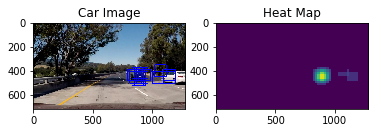

In [20]:
fin_img = pipeline_image(image)

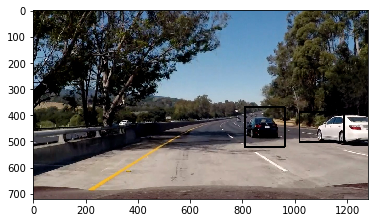

In [21]:
plt.imshow(fin_img)

# Filter Multiple and False Detections 
The false detections can be reduced by thresholding heatmap across multiple frames. I used 10 frames for thresholding. 

In [26]:
from collections import deque

def filter_bbox(img,bboxes,threshold=5):
    
    draw_image = np.copy(img)

    # Rescale data since training data extracted from 
    # .png images (scaled 0 to 1 by mpimg) and image we
    # are searching is .jpg (scaled 0 to 255)
    image = np.zeros((img.shape[0], img.shape[1]), np.float32)
    image = img.astype(np.float32)/255
   
    
    
    # Get list of windows to search at this stage.
    windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[350,700], 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size)

    # Return all the windows the classifier has predicted contain car(s) ('positive windows').
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)    

  
    bboxes.append(hot_windows)
    heatmap = np.zeros((image.shape[0], image.shape[1]), np.uint8)
    
    # Construct heatmap
    for boxlist in bboxes:
        heatmap = add_heat(heatmap, hot_windows)
    
    heatmap = apply_threshold(heatmap, threshold)
     
    final_image = draw_labeled_bboxes(draw_image, heatmap)

    return final_image

In [28]:
def process_video_pipeline(image):
    global bboxes_list    
    return filter_bbox(image, bboxes_list,threshold=10)

In [30]:
bboxes_list = deque(maxlen=20)   
img =  process_video_pipeline(image)
plt.imshow(img)

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = deque(maxlen=20)    
video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_video_pipeline) #NOTE: this function expects color images!!
video_output = "project_video_output.mp4"
%time project_clip.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [36:02<00:01,  1.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 32min 58s, sys: 24.1 s, total: 33min 22s
Wall time: 36min 4s


# Video Output

The youtube link for visoe is: https://youtu.be/ZTqC1GrmafA

# Discussion

The project gave a deep insight in some of the advanced computer vision techniques. 
The vehicles detected in the video are reasonably good. 

Area of Improvements:
1. There are still some false positives and the tracking is not that smooth.
2. The pipeline is very slow.